In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras import metrics
from sklearn.preprocessing import MinMaxScaler

In [148]:
df = pd.read_excel('../data/MERGED_DATA_INTERPOLATED2.xlsx', sheet_name='MERGE')
df.head()

,LOC_CODE,DATUM,TIJD,ZS [mg/l],ZICHT [dm],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],...,Pde,Plo,Dpu,Rte,Fja,Hak,Mhe,Dno,Dat,interpolated_columns
0,DANTZGT,1990-01-10,15:00:00,135.0,2.0,4.0,20.178571,29.19,1.645161,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,DANTZGT,1990-02-06,13:40:00,295.0,0.5,6.0,19.803571,27.37,1.177419,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['SiO2 [umol/L]', 'PO4 [umol/L]', 'pH [DIMSLS]..."
2,DANTZGT,1990-03-08,13:45:00,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,DANTZGT,1990-04-04,10:00:00,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
4,DANTZGT,1990-05-09,15:30:00,20.0,11.0,17.4,1.714286,33.28,1.161290,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


---

In [149]:
columns = list(df.columns)
location_names = df["LOC_CODE"].unique()

print("Columns: \n", columns)
print("\nLocation names: \n", location_names)
df['DATUM'] = pd.to_datetime(df['DATUM'])

# we drop the "time" and "zicht" columns
time_loc_columns = ['LOC_CODE', 'DATUM']
abiotic_columns = ['ZS [mg/l]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]']

abiotic_df = df[time_loc_columns + abiotic_columns]

abiotic_df.head()

Columns: 
 ['LOC_CODE', 'DATUM', 'TIJD', 'ZS [mg/l]', 'ZICHT [dm]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]', '    Q', 'PAR [J/m2d]', 'PAR [kJ/m2d]', 'kPAR_7d', 'kPAR_14d', 'DIN', 'DIN:SRP', 'DIN:SI', 'SRP:SI', 'IM [Jm2d]', 'Agl', 'Dbr', 'Ezo', 'Gde', 'Oau', 'Omo', 'Orh', 'Osi', 'Ram', 'Rse', 'Tec', 'Tle', 'Tni', 'Tro', 'Dle', 'Etr', 'Gfl', 'Gsp', 'Nsc', 'Pbi', 'Pbr', 'Pha', 'Stu', 'Kgl', 'Oro', 'Tor', 'Cdi', 'Cra', 'Ore', 'Ata', 'Cfu', 'Cgr', 'Lan', 'Pcl', 'Pmi', 'Pos', 'Pse', 'Cden', 'Aco', 'Dip', 'Csu', 'Mnu', 'Pco', 'Cdeb', 'Cwa', 'Pba', 'Dac', 'Ptr', 'Lun', 'Nsi', 'Rst', 'Pst', 'Acn', 'Tno', 'Ccu', 'Pan', 'Gfa', 'Hta', 'Dsp', 'Psu', 'Cei', 'Ndi', 'Cda', 'Dro', 'Cha', 'Pac', 'Cau', 'Coc', 'Pte', 'Edu', 'Mpe', 'Pde', 'Plo', 'Dpu', 'Rte', 'Fja', 'Hak', 'Mhe', 'Dno', 'Dat', 'interpolated_columns']

Location names: 
 ['DANTZGT' 'DREISR' 'GOERE6' 'GROOTGND' 'HANSWGL' 'HUIBGOT' 'L

,LOC_CODE,DATUM,ZS [mg/l],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],NO3 [umol/L],NO2 [umol/L],NH4 [umol/L],E [/m],CHLFa [ug/l]
0,DANTZGT,1990-01-10,135.0,4.0,20.178571,29.19,1.645161,7.8,37.571429,3.714286,14.071429,0.751180,1.3
1,DANTZGT,1990-02-06,295.0,6.0,19.803571,27.37,1.177419,7.9,63.428571,2.892857,11.357143,11.391822,11.2
2,DANTZGT,1990-03-08,103.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,8.642857,1.364080,21.1
3,DANTZGT,1990-04-04,113.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,6.428571,1.037580,25.0
4,DANTZGT,1990-05-09,20.0,17.4,1.714286,33.28,1.161290,8.3,0.214286,0.142857,1.928571,0.738760,10.2


## Creating train and test split

In [134]:
location_groups = abiotic_df.groupby("LOC_CODE")

train_test_dict = {}
for name, loc_df in location_groups:
    # extract year and month and put inside new column
    loc_df['YearMonth'] = loc_df['DATUM'].dt.to_period('M')
    
    loc_df = loc_df.drop(['DATUM', 'LOC_CODE'], axis=1)
    
    # calculate mean over month
    loc_df_mean = loc_df.groupby('YearMonth').mean().reset_index()
    
    train_test_dict[name] = loc_df_mean


## Scaling data before use

In [135]:
def scale_data(data, parameter_columns):
    # we gotta normalize the values for the different variables prior to analysis
    abio_data_scaler = MinMaxScaler()

    abio_data_scaler.fit(data[parameter_columns])
    data[parameter_columns] = abio_data_scaler.transform(data[parameter_columns])


for loc_name, data in train_test_dict.items():
    scale_data(data, abiotic_columns)

## Transforming data into labeled data and creating train/test split

In [136]:
train_test_ratio = 0.7

def window_sampler(df, window, parameter_columns):
	X = []
	Y = []
	dates_Y = []
	for i in range(0, len(df) - window):
		history = []
		for j in range(0, window):
			history.append(list(df[parameter_columns].iloc[(i + j)]))
		X.append(history)
		Y.append(df[parameter_columns].iloc[i + window].values)
		dates_Y.append(df["YearMonth"].iloc[i + window])
	return np.array(X), np.array(Y), np.array(dates_Y)

for i, (loc_name, data) in enumerate(train_test_dict.items()):
	print(f"LOC_NAME: {loc_name} BUSY ({i}/{len(train_test_dict) - 1})")
	X, Y, dates_Y = window_sampler(data, 6, abiotic_columns)

	tuple_list = list(zip(X, Y))

	print("sample pairs: ", len(tuple_list))

	X, Y = zip(*tuple_list)

	train_x = np.asarray(X[:int(train_test_ratio * len(X))])
	train_y = np.asarray(Y[:int(train_test_ratio * len(Y))])
	train_dates = np.asarray(dates_Y[:int(train_test_ratio * len(Y))])

	test_x = np.asarray(X[int(train_test_ratio * len(X)):])
	test_y = np.asarray(Y[int(train_test_ratio * len(Y)):])
	test_dates = np.asarray(dates_Y[int(train_test_ratio * len(Y)):])

	train_test_dict[loc_name] = ((train_x, train_y, train_dates), 
							  	(test_x, test_y, test_dates))
	print(f"LOC_NAME: {loc_name} FINISHED\n")


LOC_NAME: DANTZGT BUSY (0/26)
sample pairs:  364
110 110 254 110
LOC_NAME: DANTZGT FINISHED

LOC_NAME: DREISR BUSY (1/26)
sample pairs:  365
110 110 255 110
LOC_NAME: DREISR FINISHED

LOC_NAME: GOERE6 BUSY (2/26)
sample pairs:  356
107 107 249 107
LOC_NAME: GOERE6 FINISHED

LOC_NAME: GROOTGND BUSY (3/26)
sample pairs:  362
109 109 253 109
LOC_NAME: GROOTGND FINISHED

LOC_NAME: HANSWGL BUSY (4/26)
sample pairs:  365
110 110 255 110
LOC_NAME: HANSWGL FINISHED

LOC_NAME: HUIBGOT BUSY (5/26)
sample pairs:  362
109 109 253 109
LOC_NAME: HUIBGOT FINISHED

LOC_NAME: LODSGT BUSY (6/26)
sample pairs:  365
110 110 255 110
LOC_NAME: LODSGT FINISHED

LOC_NAME: MARSDND BUSY (7/26)
sample pairs:  363
109 109 254 109
LOC_NAME: MARSDND FINISHED

LOC_NAME: NOORDWK10 BUSY (8/26)
sample pairs:  362
109 109 253 109
LOC_NAME: NOORDWK10 FINISHED

LOC_NAME: NOORDWK2 BUSY (9/26)
sample pairs:  358
108 108 250 108
LOC_NAME: NOORDWK2 FINISHED

LOC_NAME: NOORDWK20 BUSY (10/26)
sample pairs:  359
108 108 251 108


## Defining the LSTM model

In [152]:
class MultivariateLSTM:
    def __init__(self, input_shape, output_dimensionality, LSTM_units=256, dropout_prob=0.2, loss="MeanSquaredError", chosen_metrics=[metrics.mean_squared_error,
                    metrics.mean_absolute_error], optimizer="Adam", activation="linear"):
    
        self.output_dimensionality = output_dimensionality
        self.input_shape = input_shape
        self.location_name = None

        self.period_converter = np.vectorize(lambda x: x.year + ((x.month - 1) / 12))

        self.model = keras.Sequential()
        self.model.add(Input(shape=(input_shape[0], input_shape[1])))
        self.model.add(keras.layers.LSTM(LSTM_units))
        self.model.add(keras.layers.Dropout(dropout_prob))
        self.model.add(keras.layers.Dense(output_dimensionality, activation=activation))
        self.model.compile(loss = loss, metrics=chosen_metrics, optimizer=optimizer)
        self.model.summary()
    
    def train(self, data_dict, location_name, epochs=50):
        X_train = data_dict[location_name][0][0]
        Y_train = data_dict[location_name][0][1]

        self.location_name = location_name

        return self.model.fit(X_train, Y_train, epochs=epochs)
    
    def predict(self, data_dict, plot=False, plot_settings=((4, 8), 2)):
        if self.location_name is None:
            print("Train the model first using model.train(data_dict, location_name, [epochs])")
            return

        X_test, y_test, dates = data_dict[self.location_name][1]

        dates = self.period_converter(dates)

        predicted_values = self.model.predict(X_test)

        if plot:
            self.plot_extrapolated_data(predicted_values, y_test, dates, abiotic_columns, *plot_settings)

        return predicted_values

    def plot_extrapolated_data(self, predicted_values, actual_values, dates, columns, subplotsize=(4, 8), colcount=2):
        rowcount = int(math.ceil(len(columns) / colcount))
    
        _, ax = plt.subplots(rowcount, colcount, 
                            figsize=(subplotsize[1] * colcount, subplotsize[0] * rowcount))

        for i, column in enumerate(columns):
            data = {
                'Predicted': predicted_values[:, i],
                'Actual': actual_values[:, i]
            }
            ax[i // colcount][i % colcount].plot(dates, data['Actual'], linestyle='--')
            ax[i // colcount][i % colcount].plot(dates, data['Predicted'])
            ax[i // colcount][i % colcount].set_title(column)

LSTM_model = MultivariateLSTM(input_shape=(train_x[0].shape[0], train_x[0].shape[1]), output_dimensionality=11)

    

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 256)            │       274,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,259 (1.06 MB)

 Trainable params: 277,259 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [153]:
history = LSTM_model.train(train_test_dict, "DANTZGT", epochs=50)

Epoch 1/50


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1025 - mean_absolute_error: 0.2354 - mean_squared_error: 0.1025  
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0398 - mean_absolute_error: 0.1555 - mean_squared_error: 0.0398 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0319 - mean_absolute_error: 0.1347 - mean_squared_error: 0.0319 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0255 - mean_absolute_error: 0.1199 - mean_squared_error: 0.0255 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0234 - mean_absolute_error: 0.1113 - mean_squared_error: 0.0234 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0208 - mean_absolute_error: 0.1069 - mean_squared_error: 0.0208 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0197 - mean_absolute_error: 0.1039 - mean_squared_error: 0.0197 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0199 - mean_absolute_error: 0.1025 - mean_squared_error: 0.0199 
Epoch 9/50
8/8 ━━━━━━━━━━━

## Plotting results

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


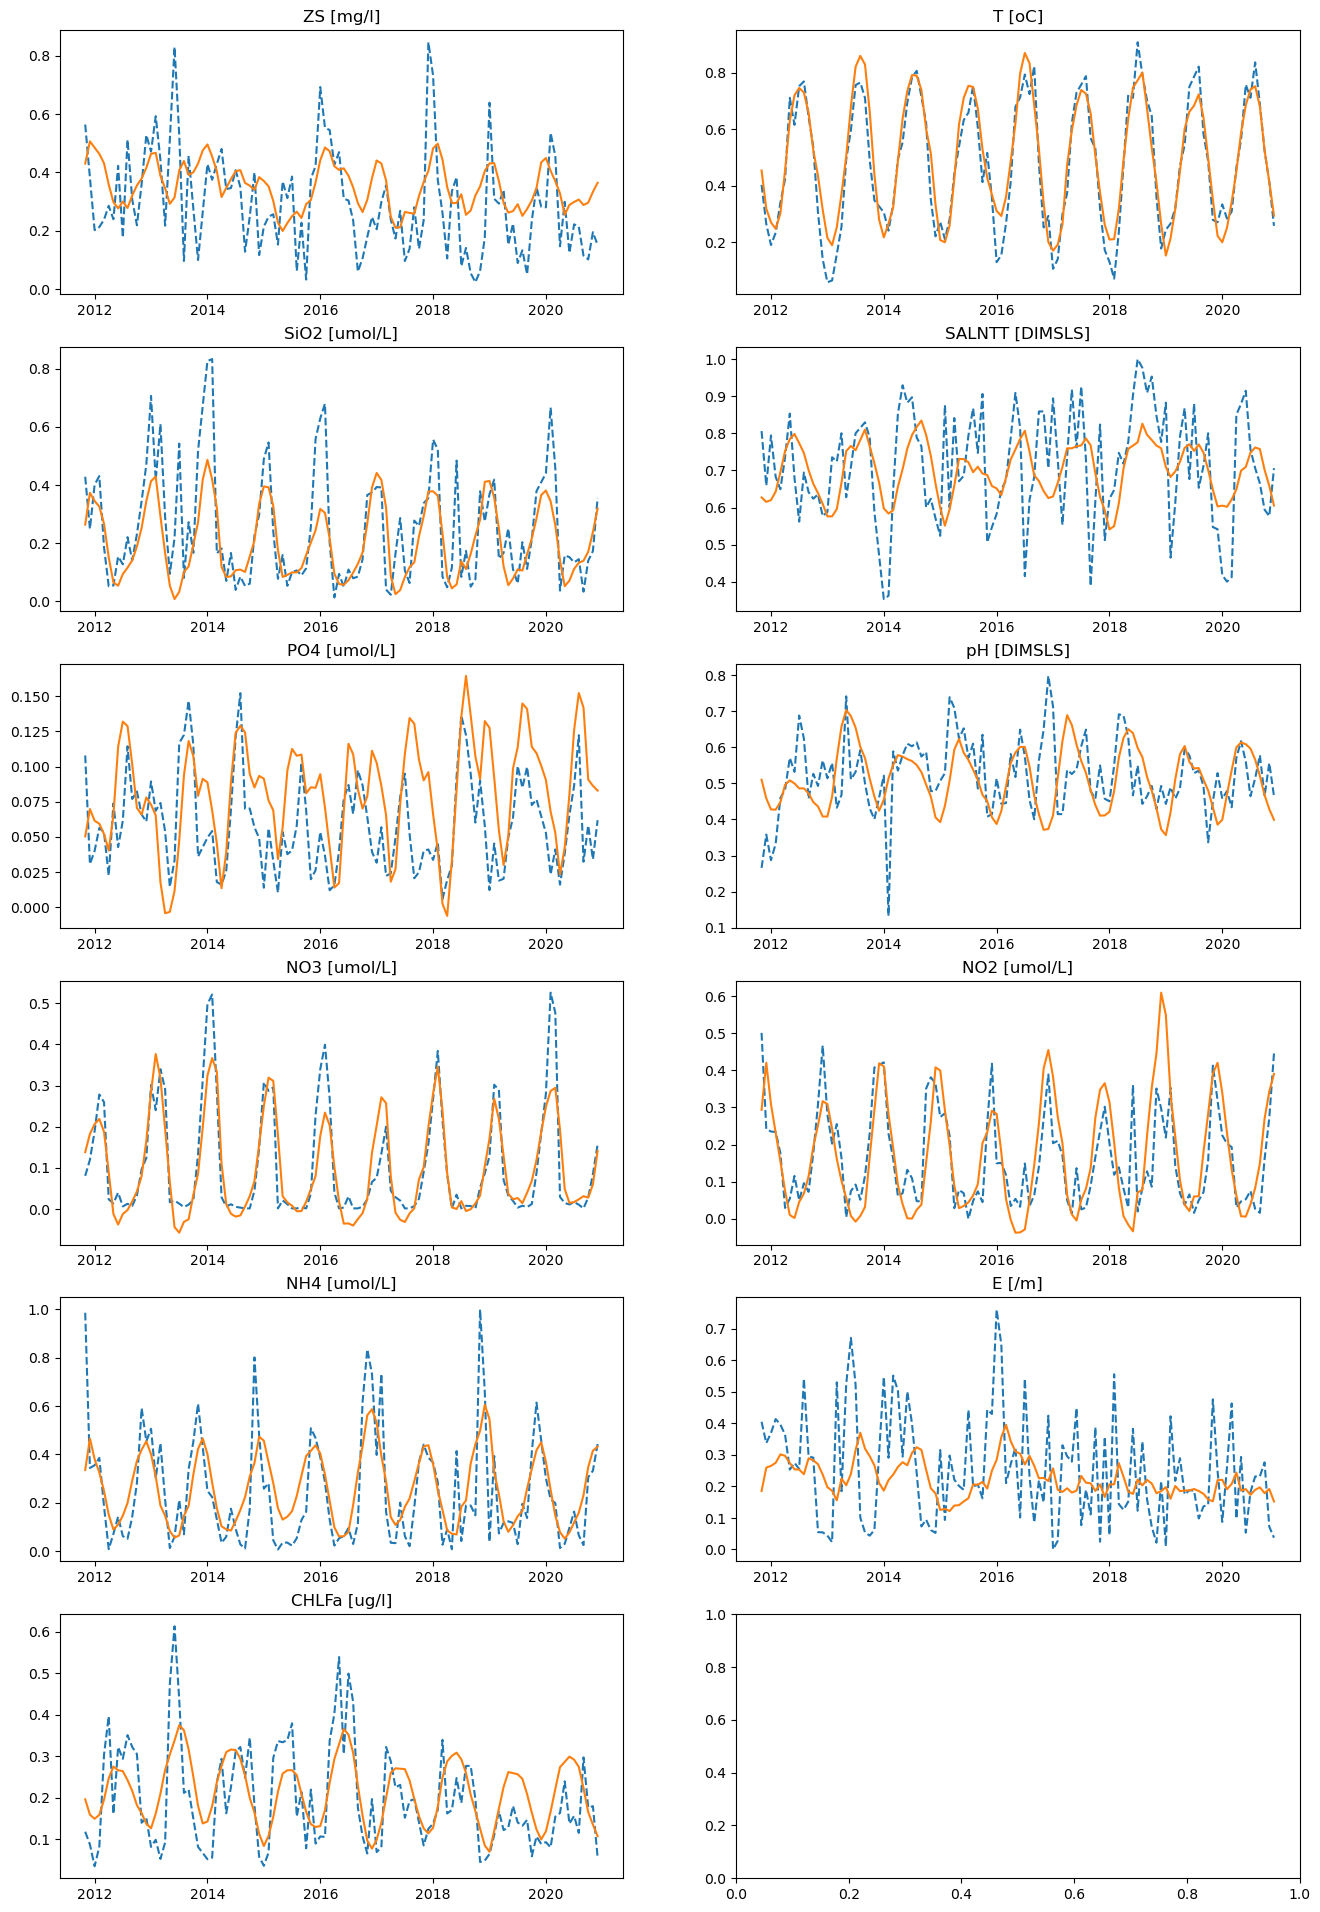

In [154]:
predicted_values = LSTM_model.predict(train_test_dict, plot=True)